# Multifeature logistic decoders

The ECoG recordings feature multiple channels, and the signal on each channel can be decomposed into multiple frequency bands. Changes in activities in both the high and low frequency bands changed during finger flexions. Can we use this multichannel and multifrequency activity to decode finger flexions? So far we have built logistic decoders that use only a single feature, but we may be able to get better performance if multiple features were used. This week we will discuss how to use logistic decoders with multiple features.

In [1]:
import os.path as op
import sys
from itertools import product
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from source.utils import zscore
from source.loaders import EcogFingerData
from matplotlib import animation
from IPython.display import HTML
import torch
from torch.utils.data import Dataset, DataLoader


## Spatial pattern of spectral changes

Last week we started working with ECoG recordings from subjects while they moved their fingers. The grid had 64 electrodes placed directly on the cortical surface. When a subject moved a finger there was a localized pulse of activity over part of the cortex. This appeared as an ERP, but also as an increased incidence of high frequency activity bursts, and a decrease in low frequency power. These bursts are closely related to local processing in the cortex. Since different parts of cortex control different parts of the body (including individual fingers), each motor action would create a different pattern of high frequency bursts acros the ECoG array.

Let's load the data from last week and see if spectral activity differed in their spatial pattern across different finger movements.

In [2]:
subj = 'cc'
ecog_path = ['..', 'data/ecog/', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path)

ecog_data = EcogFingerData(ecog_file)

Now we will get the flexion event times.

In [3]:
flex_events = {}
for finger in ['thumb', 'index', 'middle', 'ring', 'little']:
    flex_events[finger] = ecog_data.detect_flex_onsets(finger)

Let's examine the spectrogram associated with the start of thumb flexions. Since we have 63 channels to choose from, we will focus on just one, channel 20.

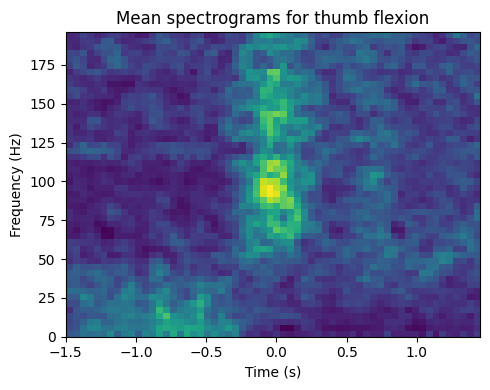

In [4]:
# get spectrograms for thumb flexion
f, t, S = ecog_data.get_spec(event_ts=flex_events['thumb'], chans=20, pre_t=1.5, post_t=1.5, freq_max=200)

# plot mean spectrograms for each finger
fig, ax = plt.subplots(figsize=(5, 4))
mean_spec_z = np.mean(zscore(S, axis=3), axis=0)
ax.imshow(mean_spec_z.squeeze(), aspect='auto', origin='lower', 
                  extent=(t[0], t[-1], f[0], f[-1]))
ax.set_title('Mean spectrograms for thumb flexion')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
fig.tight_layout()

We can see that the spectral changes start approximately two hundred milliseconds prior to the finger movement, and end about two hundred milliseconds after. This is the event we wish to detect. So, we will sample the spectrogram for 200 ms before and after the movement onset.

This is just one channel and one movement type. It does not give us a sense of how spectral changes vary across movement types and channels. It would be tedious to plot every spectrogram for every channel and movement. Instead, we will plot the mean spectrum during the +/-200 ms surrounding for each channel and finger flexion. These will be z-scored with respect to a baseline period centered at 1.5 seconds prior to the movement onset.

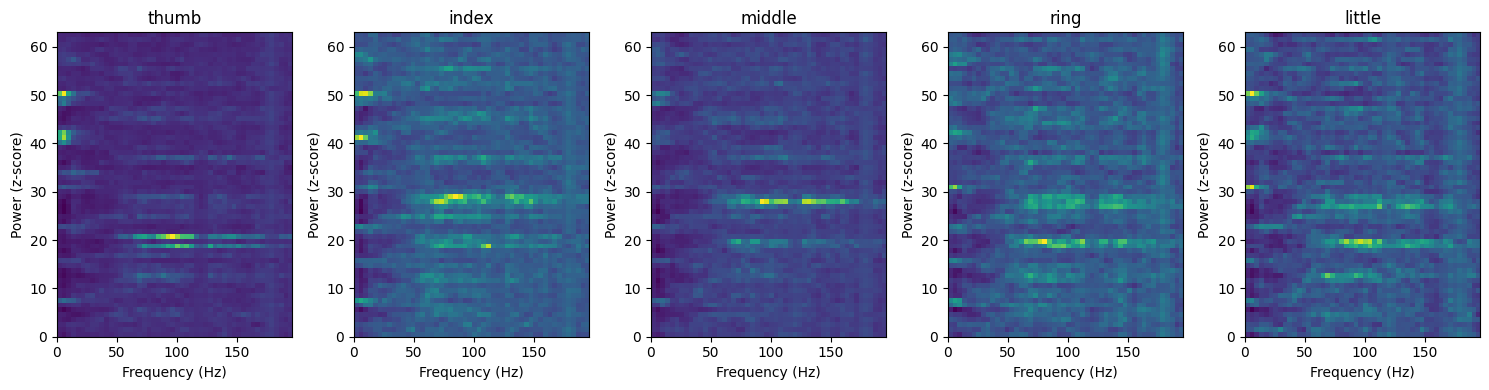

In [5]:
# calculate z-scored spectrums for each finger
S_on = {}
S_base = {}
S_on_z = {}
S_on_mean_z = {}
for finger, events in flex_events.items():
    f,t,S_on[finger] = ecog_data.get_spec(event_ts=events, pre_t=0.2, post_t=0.2, freq_max=200)
    _,_,S_base[finger] = ecog_data.get_spec(event_ts=events-1.5, pre_t=0.2, post_t=0.2, freq_max=200)

    # to convert our spectrograms to z-scored spectrums, let's break the steps apart
    # get mean and standard deviation for each frequency and channel
    S_base_mean = np.mean(S_base[finger], axis=(0,3))[:, :, np.newaxis]
    S_base_std = np.std(S_base[finger], axis=(0,3))[:, :, np.newaxis]

    # z-score each frequency and channel
    S_on_z[finger] = (S_on[finger] - S_base_mean) / S_base_std

    # average across trials and time
    S_on_mean_z[finger] = np.mean(S_on_z[finger], axis=(0, 3)) 

# plot mean spectrograms for each finger
fig, ax = plt.subplots(1,5, figsize=(15, 4))
for i, (finger, spec) in enumerate(S_on_mean_z.items()):
    ax[i].imshow(spec[:-1,:], aspect='auto', origin='lower', 
                  extent=(f[0], f[-1], 0, spec.shape[0]))
    ax[i].set_title(finger)
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel('Power (z-score)')

fig.tight_layout()


In the above plot, each subplot is a different finger flexion. The increases in high frequency power varies across movement types. For instance, the peak channels for thumb flexions are on channels 18 and 20, while for the index finger they are on the 27th and 28th. The decrease in low frequency power is less channel specific, but they too may prove informative. Thus, we want to use these channel specific spectral differences to try and decode whether a specific movement occurred. 

We can plot these onto the ECoG grid, to get a better sense of the spatial distribution of these two bands of activity.

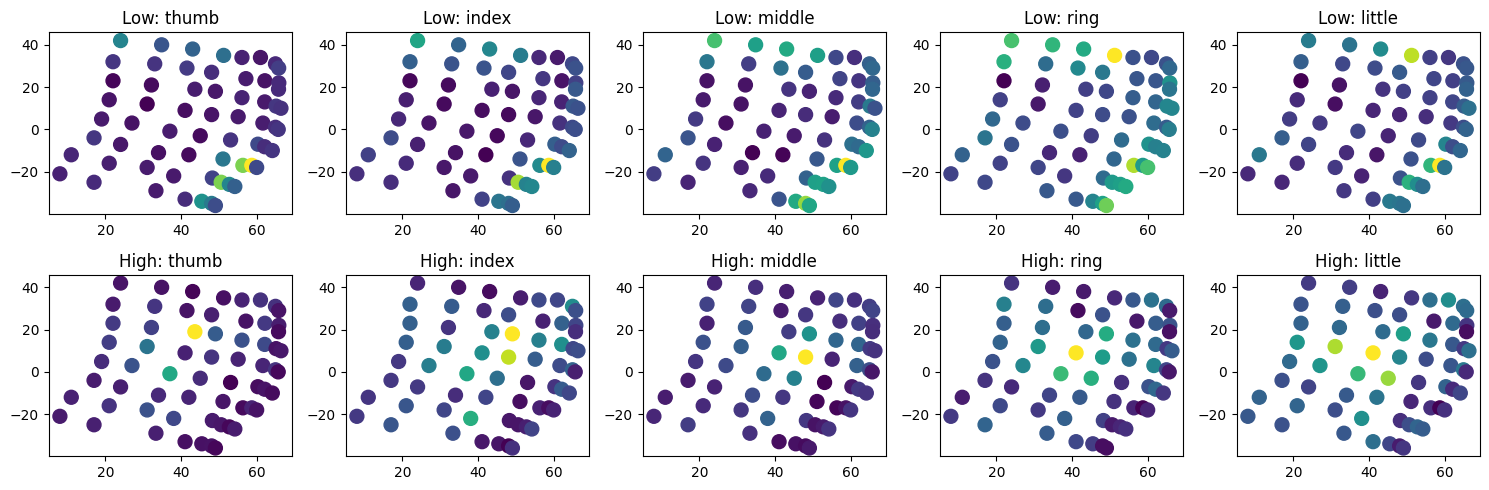

In [6]:
# frequency bands of interest
low_freqs = f<20
high_freqs = (f>50)&(f<100)

# mean power in low and high frequency bands for each finger and channel
low_power = {}
high_power = {}
for finger, spec in S_on_mean_z.items():
    low_power[finger] = np.mean(spec[:, low_freqs], axis=1)
    high_power[finger] = np.mean(spec[:, high_freqs], axis=1)

# plot ECoG electrode sites colored by spectral power
fig, ax = plt.subplots(2,5, figsize=(15, 5))
for i, (finger, power) in enumerate(low_power.items()):
    ecog_data.plot_ecog_data(low_power[finger], ax=ax[0,i], s=100)
    ax[0,i].set_title('Low: ' + finger)
    ecog_data.plot_ecog_data(high_power[finger], ax=ax[1,i], s=100)
    ax[1,i].set_title('High: ' + finger)
fig.tight_layout()



Laying out the spectral power across the ECoG grid makes the movement-related patterns more apparent. We divided spectral power into low (<20 Hz) and high (>50 Hz) bands, and plotted them on each ECoG grid location. For the low power, there was not much differentiation between movement types. The top left and bottom right portions of the grid showed consistant elevations, and the middle was low. On the other hand, high frequency power was elevated on distinct sets of electrodes near the middle of the array. This difference is crucial for classifying each type of movement. Some movements, such as thumb raising, strongly activate only one site, while others, such as little finger movement, activate 3.

In the ERP decoding we did previously, we focused on just a single electrode and measure, the match to the ERP. While we may be tempted to take the same approach here, such as measuring the high frequency power on the electrode where it is strongest for each movement, the other sites might offer additional information for decoding. For instance, two sites show substantial increases in high frequency power for index finger movement. If the activation on those sites is perfectly correlated, then we could use just one of them without losing information. But imagine that one of the sites is active on half the trials, and the other is activated on the other half. In that case, only focusing on one of them means we could miss 50% of movements. Instead, we would want to pool them together.

We can see if this is the case by plotting the relationship between the activation on those sites across trials.

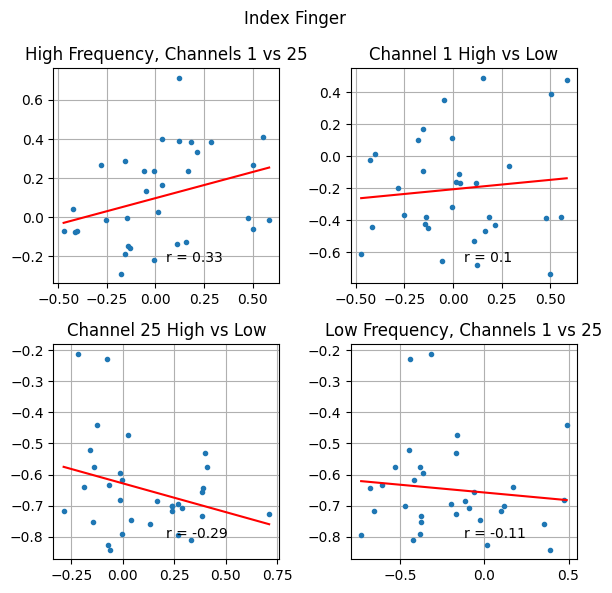

In [7]:
# plot mean power in low and high frequency bands for index finger movements on each channel and epoch
index_spec_low = np.mean(S_on_z['index'][:,:,low_freqs,:], axis=(2,3))
index_spec_high = np.mean(S_on_z['index'][:,:,high_freqs,:], axis=(2,3))

# identify top two channels for high frequency power
top_chans = np.argsort(np.mean(index_spec_high, axis=1))[-2:]


# function for scatter plot with best fit line and correlation coefficient
def scatter_fit(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, '.')
    # add linear fit and correlation coefficient to plot
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'r')
    ax.text(0.5, 0.1, 'r = ' + str(np.round(np.corrcoef(x, y)[0,1], 2)), transform=ax.transAxes)
    ax.grid()
    return ax

# plot mean power in low and high frequency bands for index finger movements on each channel and epoch
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
scatter_fit(index_spec_high[:,top_chans[0]], index_spec_high[:,top_chans[1]], ax=ax[0,0])
ax[0,0].set_title('High Frequency, Channels ' + str(top_chans[0]) + ' vs ' + str(top_chans[1]))

scatter_fit(index_spec_low[:,top_chans[0]], index_spec_low[:,top_chans[1]], ax=ax[1,1])
ax[1,1].set_title('Low Frequency, Channels ' + str(top_chans[0]) + ' vs ' + str(top_chans[1]))

scatter_fit(index_spec_high[:,top_chans[0]], index_spec_low[:,top_chans[0]], ax=ax[0,1])
ax[0,1].set_title('Channel ' + str(top_chans[0]) + ' High vs Low')

scatter_fit(index_spec_high[:,top_chans[1]], index_spec_low[:,top_chans[1]], ax=ax[1,0])
ax[1,0].set_title('Channel ' + str(top_chans[1]) + ' High vs Low')
fig.suptitle('Index Finger')
fig.tight_layout()


Focusing on the two sites with the strongest high frequency activity during index finger movements, we can see that they are correlated, but not perfectly. In the top left plot, where we compare high frequency activity between both top sites, we can see that they have a correlation coefficient around 0.33. This means that on any given index finger movement the sites are not providing redundant information, so it makes sense to combine them. A similar trend is seen for low frequency power (lower right plot). In addition, low and high frequency power was partially anticorrelated at each site. Altogether, the lack of perfect correlations (r = 1) means that we should try to combine these measures when estimating whether an index finger was moved. This requires that our logistic decoder accepts multiple features.

## Multifeature logistic decoder
The logistic decoders we ran previously accepted just a single input. Now, however, we want to use many inputs. These will be the spectrum for each channel. With 63 channels and 50 frequencies that means we would supply 3150 features ($63 \times 50$). This requires a subtle change to the equation we use for the logistic model. Recall that the original equation with 1 feature was:

$$ \sigma(x) = \frac{1}{1+e^{-(b+wx)}} $$

Here $x$ represents the one feature, along with $w$ being the weight for that feature. If we want to include multiple features, we can write the equation as:

$$ \sigma(x) = \frac{1}{1+e^{-(b+w_1x_1+w_2x_2+...w_nx_2)}} $$

where there are $n$ different features. Alternatively, we can write it using the summation symbol as:

$$ \sigma(x) = \frac{1}{1+e^{-(b+\sum_{i=1}^{n}w_ix_i)}} $$

Lastly, dusting off our linear algebra, we can treat $w$ and $x$ as vectors, $W$ and $X$ respectively:

$$ \sigma(x) = \frac{1}{1+e^{-(b+W \cdot X)}} $$

Fortunately, SciKit learn makes it trivial to add additional features to our logistic regression model. Previously we supplied our ERP measures across trials as a vector to the `LogisticRegression` classifier's `fit` method. Now, we want to supply multiple measures, the spectral power at each frequency and channel, for multiple trials. That means we will supply a matrix of data. The `LogisticRegression` classifier object can handle that, with trials along the row axis, and features along the columns axis. So we just have to reshape our data into that format. We also need to include some 'null' movement periods for training the classifier.

In [8]:
# minimum time between thumb flexion events
min_times = [np.min(np.diff(events)) for _, events in flex_events.items()]
print('Minimum time between flexion events: {:0.2f} s'.format(np.min(min_times)))

Minimum time between flexion events: 3.28 s


Since the minimum time between flexions is ~3.3 s, we create our null events by offsetting the flexion times by 1 second. With the 200 ms windows around each flexion, we should not overlap with another flexion of the same finger. We will train our decoder to pick up thumb movements.

In [9]:
def format_ecogfinger_data(data=None, finger='thumb'):
    """Format ECoGFinger data for decoding.
    
    Parameters
    ----------
    data : EcogFingerData
        Data to format.
    finger : str
        Finger to decode.

    Returns
    -------
    X : array, shape (n_epochs, n_features)
        Features for each epoch.
    y : array, shape (n_epochs,)
        Labels for each epoch.
    """

    # get flexion event times
    flex_events = data.detect_flex_onsets(finger)

    # get movement and null spec epochs, 1 s after each thumb flexion event
    _,_,flexes = data.get_spec(event_ts=flex_events, pre_t=0.2, post_t=0.2, freq_max=200)
    _,_,nulls = data.get_spec(event_ts=flex_events-1, pre_t=0.2, post_t=0.2, freq_max=200)

    # mean power across time for each epoch
    flexes = np.mean(flexes, axis=3)
    nulls = np.mean(nulls, axis=3)

    # z-score each frequency and channel
    _,_,total_data = data.get_spec(freq_max=200)
    
    z_mean = np.mean(total_data, axis=3).squeeze() # squeeze to remove singleton epoch dimension
    z_std = np.std(total_data, axis=3).squeeze() 
    flexes = (flexes - z_mean) / z_std
    nulls = (nulls - z_mean) / z_std

    # create labels for thumb movements and nulls
    lbls = np.hstack((np.ones(flexes.shape[0]), np.zeros(nulls.shape[0])))

    # stack flexes and thumb_nulls along first dimension
    feats = np.vstack((flexes, nulls))

    # reformat features so that each trial is a row and each column is a feature
    feats = feats.reshape(feats.shape[0],-1)

    return feats, lbls

thumb_feats, thumb_lbls = format_ecogfinger_data(ecog_data, finger='thumb')

A quick note about z-scoring: when you transform your samples based on other samples, you open yourself up to the possbility of *data leakage*. This means that the transformed samples are partly dependent on the the values from other samples. When building a decoder, it may pick up on this dependency, leading to improved performance that is spurious. In our case, since we are taking the mean and standard deviation across the entire session, the cross-contamination between movement and null samples will be minimized. However, if we just derived those measures from the samples we trained our decoder on, then there would be a far greater chance of improved decoding owing simply to data leakage.

It is usually a good idea to plot our data before passing it to a model, just to make sure it is formatted correctly.

Text(0.5, 1.0, 'Thumb Movement Features')

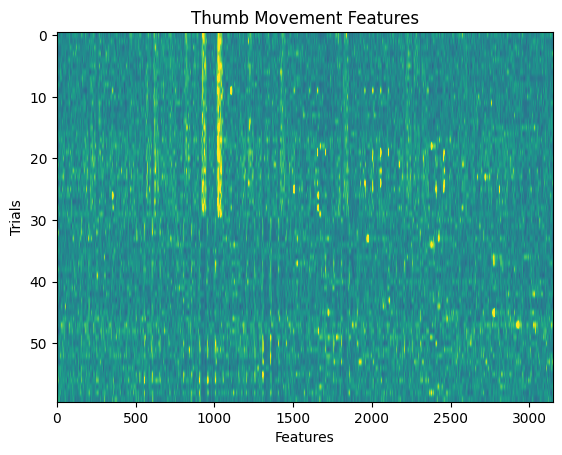

In [10]:
# plot thumb movement features
plt.imshow(thumb_feats, aspect='auto', vmin=-2, vmax=2)
plt.xlabel('Features')
plt.ylabel('Trials')
plt.title('Thumb Movement Features')

The first 33 trials had thumb movements. Each row is a spectrum from a channel, repeated for each channel. This results in a banding pattern for those channels with with high frequency bursts during movement. Those bands go away on the null trials, while thumb movements were not present.

Now that the data is formatted right, we can pass it to the SciKit learn `LogisticRegression` function and see how well we predict thumb movements.

In [11]:
# create logistic regression model
log_mdl = LogisticRegression(penalty=None)
log_mdl.fit(thumb_feats, thumb_lbls)

# get model predictions
thumb_preds = log_mdl.predict(thumb_feats)

# get model accuracy
thumb_acc = balanced_accuracy_score(thumb_lbls, thumb_preds)
print('Thumb movement decoding accuracy: {:0.2f}%'.format(thumb_acc*100))

Thumb movement decoding accuracy: 100.00%


Thumb flexion can be predicted with 100% accuracy when we use the spectrums from the ECoG channels. This is far better than our ability to predict stimulus presentation with the ERP. In fact, it is so good we should be suspicious. If we think about what the decoder is doing, it is trying to generate the correct label based on the features we supply to it. In this case, we have 60 trials to predict using 3150 features. Since we have far more features than trials, it is possible that the decoder is just picking up on a specific pattern of features for each individual trial that are unrelated to whether the thumb was moving or not. We can see whether this is a possiblity by seeing if the logistic decoder can perform even if we scramble the trial labels, essentially destroying the relationship between the features and thumb movement. In that case, the only solution the decoder can use is to memorize specific patterns associated with each trial.

In [12]:
log_mdl_sc = LogisticRegression(penalty=None)

# scramble trial labels
thumb_lbls_sc = np.random.permutation(thumb_lbls)

# test logistic regression model with scrambled labels
log_mdl_sc.fit(thumb_feats, thumb_lbls_sc)

# get model predictions
thumb_preds_sc = log_mdl_sc.predict(thumb_feats)

# get model accuracy
thumb_acc_sc = balanced_accuracy_score(thumb_lbls_sc, thumb_preds_sc)
print('Thumb movement decoding accuracy: {:0.2f}%'.format(thumb_acc_sc*100))

Thumb movement decoding accuracy: 100.00%


Oh dear! Perfect performance, even with scrambled labels. How can we control for this?

Recall that when we trained the ERP decoder we used two seperate sets of data, one for training and the other for testing. This means the decoder may memorize specific trials, but it won't help because it is tested on trials it has never seen. 

Median train accuracy: 100.00 %
Median test accuracy: 95.83 %


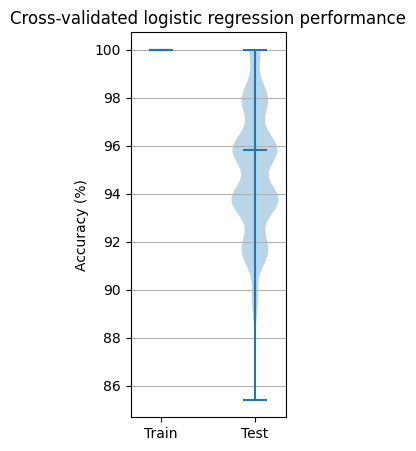

In [13]:
# Fit and evalulate logistic regression model to ECoG spectra using cross-validation
def logreg_traintest(feats, lbls, k, **kwargs):
    """
    Function to train and test a logistic regression model using k-fold cross-validation.

    Parameters
    ----------
    feats : array
        Array of features, where each row is a trial and each column is a feature.
    lbls : array
        Array of labels, where each element is the label for the corresponding row in feats.
    k : int
        Number of folds for cross-validation.
    **kwargs : dict
        Keyword arguments for sklearn.linear_model.LogisticRegression.

    Returns
    -------
    score_train : float
        Balanced accuracy score for training data.
    score_test : float
        Balanced accuracy score for testing data.
    """

    # split data into train and test sets
    kstratsplit = StratifiedKFold(n_splits=k, shuffle=True)
    test_idxs, train_idxs = next(kstratsplit.split(feats, lbls))
    feats_test = feats[test_idxs,:]
    feats_train = feats[train_idxs,:]
    lbls_test = lbls[test_idxs]
    lbls_train = lbls[train_idxs]

    # fit logistic regression model
    log_mdl = LogisticRegression(**kwargs)
    log_mdl.fit(feats_train, lbls_train)

    # get model predictions
    lbls_train_pred = log_mdl.predict(feats_train)
    lbls_test_pred = log_mdl.predict(feats_test)

    # get model accuracy
    score_train = balanced_accuracy_score(lbls_train, lbls_train_pred)
    score_test = balanced_accuracy_score(lbls_test, lbls_test_pred)

    return score_train*100, score_test*100

# Run logistic regression model on ERP data
num_runs = 1000
scores_train = np.zeros(num_runs)
scores_test = np.zeros(num_runs)
for i in range(num_runs):
    scores_train[i], scores_test[i] = logreg_traintest(thumb_feats, thumb_lbls, 5, penalty=None)

# plot violin plot of scores compared across train and test sets
fig, ax = plt.subplots(figsize=(2,5))
ax.violinplot([scores_train, scores_test], showmedians=True)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy (%)')
ax.grid(axis='y')
ax.set_title('Cross-validated logistic regression performance')

# print median performance for train and test sets
print('Median train accuracy: {:.2f} %'.format(np.median(scores_train)))
print('Median test accuracy: {:.2f} %'.format(np.median(scores_test)))

Whoa, back down to reality. The performance on the test set is around ~96%, while the training is stuck at 100%. This suggests that the decoder is not entirely working through memorization of specific trials. If it had been, then performance on the test set would be at chance, around 50%. Instead, it is picking up on some features in the data that are commonly expressed during thumb flexion events and that generalize to the test set. However, some memorization is happening that gives it 100% performance on the training set. It is that bit of memorization we want to try minimize. 

But how?

## Regularization
The problem has been that we have so many features accessible to the decoder now that it can now *overfit* the data. By overfitting, we mean that the model tries to capture all the variability in the training data. A good example of this phenomenon is fitting a curve to a set of data points.

Imagine we have two variables, $x$ and $y$, that are related to each other by the equation $y=x+\epsilon$. Here $\epsilon$ is some noise that makes $x$ and $y$ only partially correlated. We want to predict the value of `y` given the value of `x`. There are a host of models that can be used. One is a linear model, where $y=b+wx$. 

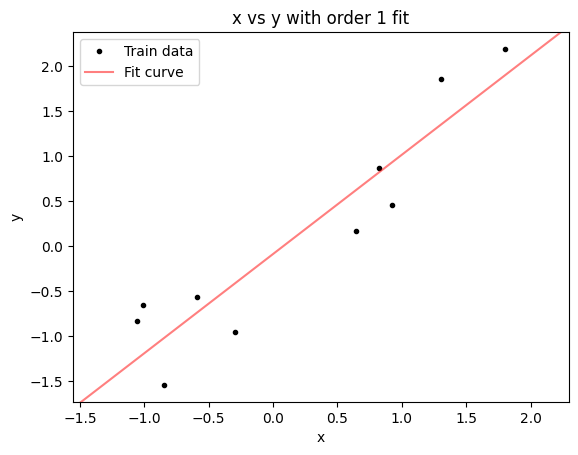

In [14]:
# create two partially correlated variables
np.random.seed(47)
x = np.random.randn(10)
y = x + np.random.randn(10)/2 # y is partially correlated with x

def plot_w_fit(x, y, mdl_order=1, ax=None):
    """
    Function to plot data and fit a linear model.

    Parameters
    ----------
    x : array
        Array of x values.
    y : array
        Array of y values.
    mdl_order : int
        Order of polynomial to fit to data.
    ax : matplotlib.axes.Axes
        Axis to plot on.
    """

    if ax is None:
        ax = plt.gca()

    min_x = np.min(x)-0.5
    max_x = np.max(x)+0.5
    x_samples = np.linspace(min_x,max_x,100)
    # plot x vs y
    ax.plot(x, y, 'k.', label='Train data')
    y_lim = ax.get_ylim()
    # plot polynomial fit
    ax.plot(x_samples, np.poly1d(np.polyfit(x, y, mdl_order))(x_samples), 'r', alpha=0.5, label='Fit curve')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim(y_lim)
    ax.set_xlim([min_x, max_x])
    ax.set_title('x vs y with order {} fit'.format(mdl_order))

plot_w_fit(x,y)
plt.legend()

A linear fit captures the trend, larger values of x lead to larger values of y, but almost none of the data points lie along the best fit line. The linear equation is a polynomial with order=1. What happens if we increase the model order? To do that, we can keep including additional terms, $y = b + m_1x + m_2x^2$, $y= b + m_1x + m_2x^2 + m_3x^3$, and so on.

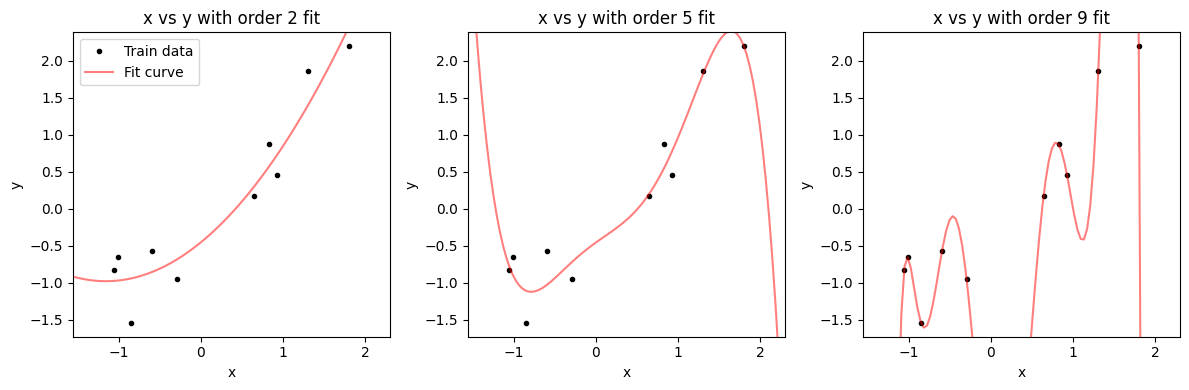

In [15]:
# plot x vs y with fits of different orders
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plot_w_fit(x, y, 2, ax=ax[0])
ax[0].legend()
plot_w_fit(x, y, 5, ax=ax[1])
plot_w_fit(x, y, 9, ax=ax[2])
fig.tight_layout()


As we increase the order, the fitted line gets closer to the data points. If our order is equal to the number of data points, then the line passes through each point. However, between points it deviates dramatically. If we generate additional data points using the same rule, we will find that higher order fits are even worse then the lower order ones.

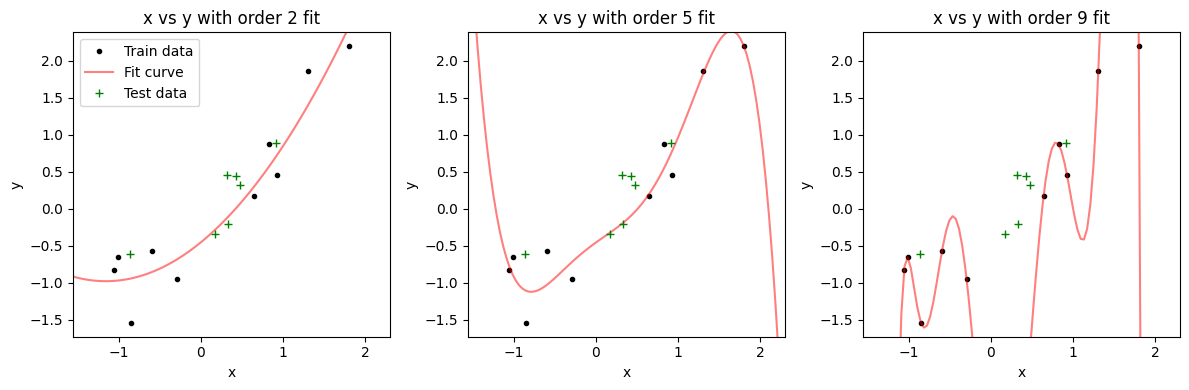

In [16]:
# generate new data using the same process
x_new = np.random.randn(10)
y_new = x_new + np.random.randn(10)/2

# plot x vs y with fits of different orders
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plot_w_fit(x, y, 2, ax=ax[0])
ax[0].plot(x_new, y_new, 'g+', label='Test data')
ax[0].legend()
plot_w_fit(x, y, 5, ax=ax[1])
ax[1].plot(x_new, y_new, 'g+')
plot_w_fit(x, y, 9, ax=ax[2])
ax[2].plot(x_new, y_new, 'g+')
fig.tight_layout()


The higher order models better fit the data points they are fitted (i.e. trained) on, but poorly on those data points they are not (green crosses). In fact, increasing model order seems to worsen the fit to the held out data. We show this by measuring the mean squared error betwween the fitted line and the data it was, or was not, trained on, for models of different order.

Text(0.5, 1.0, 'Train and test errors for models of different orders')

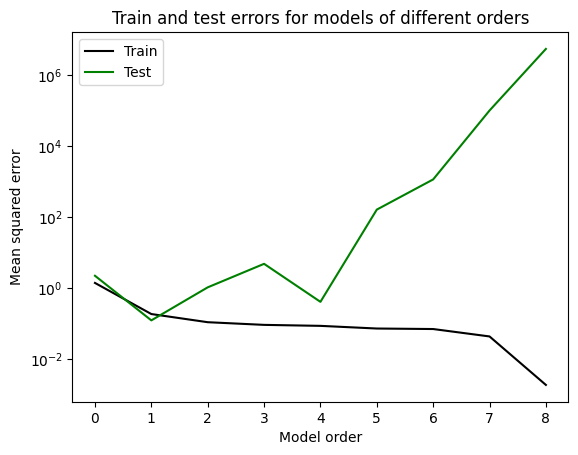

In [17]:
ord_list = np.arange(0, 9)
train_err = np.zeros(ord_list.size)
test_err = np.zeros(ord_list.size)

# fit models of different orders and get train and test errors
for i in ord_list:
    mdl = np.poly1d(np.polyfit(x, y, i))
    train_err[i] = np.mean((y - mdl(x))**2)
    test_err[i] = np.mean((y_new - mdl(x_new))**2)

# plot train and test errors
plt.plot(ord_list, train_err, color='k', label='Train')
plt.plot(ord_list, test_err, color='g', label='Test')
plt.yscale('log')
plt.xlabel('Model order')
plt.ylabel('Mean squared error')
plt.legend()
plt.title('Train and test errors for models of different orders')


As we increase the model order, the error on the training data keeps decreasing. If we get to a model order of 9 (not plotted), the error drops to 0, which reflects the fact that the curve can now pass through each data point. On the other hand, the error on the test data decreases, then increases. It reaches its minimum at a model of order 1, which reflects the fact that the data was generated by a linear model, $y=x$. As the order increases past 1, the error increases, because the model is now making predictions between the training data points that are deviating from the underlying linear function that generates the data. This is the problem with overfitting, and why it is crucial to use seperate training and test data sets to evaluate the performance of decoders.

With the polynomial fit, it is straightforward to set the model order to minimize error on the test data set. For our logistic regression decoder, which has 3150 features, and that we are not clear about which ones to select or suppress, this is more challenging. 

### L2 and L1 penalties
One solution is to add a term to the loss function that penalizes it for using more weights, i.e. setting them to values other than 0. This is referred to as *penalty term*. The degree to which we allow this penalty term to influence the loss is set by the $\lambda$ parameter. There are different functions, called *norms*, for measuring the strength of the weights. If we take the mean squared value of the weights, that is referred to as the L2 norm, or *ridge regression*. This is written as:

$$ loss = loss_{fit} + \lambda\sum_{i=0}^{n}w_i^2 $$

The consequence of this is that large weights shrink to smaller values while still minimizing the $loss_{fit}$. The degree to which one emphasizes minimizing the weights is set by the $\lambda$ parameter. If $\lambda$ is set to 0, then the equation is the same loss function we have been using normally without regularization. As $\lambda$ increases, the penalty on weights becomes more stringent, pushing them towards 0. 

How does this affect the loss landscape? We can imagine it as being the summation of two surfaces, one for $loss_{fit}$ and another for $\lambda\sum_{i=0}^{n}w_i^2$. We can contrive a convex $loss_{fit}$, and then vary the strength of $\lambda$, to see how it distorts it.

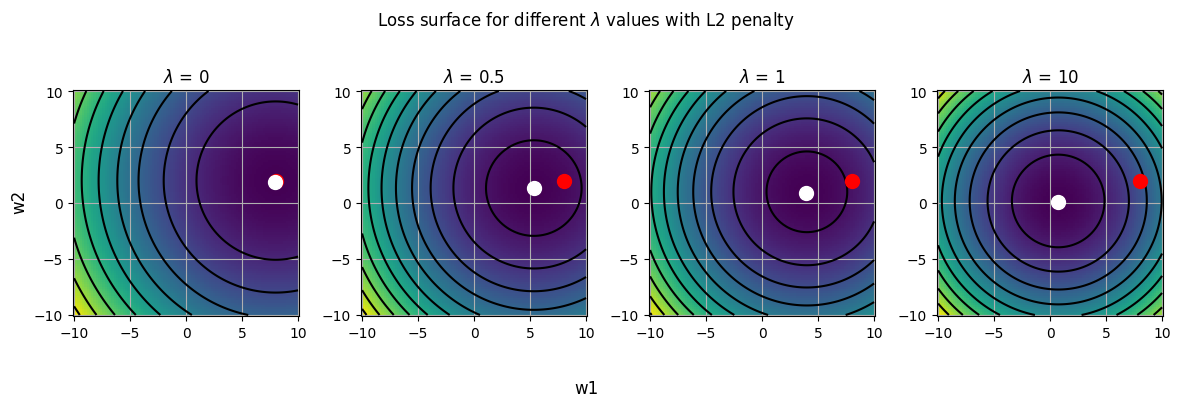

In [18]:
# create loss surface as quadratic function of two variables
w1 = np.linspace(-10, 10, 100)
w2 = np.linspace(-10, 10, 100)
w11, w22 = np.meshgrid(w1, w2)
loss_fit = (w11-8)**2 + (w22-2)**2

# create L2 penalty surface
pp = w11**2 + w22**2

# lambda list
lambdas = [0, 0.5, 1, 10]

# plot loss surface
fig, ax = plt.subplots(1,4,figsize=(12,4))
for ind, lam in enumerate(lambdas):
    curr_loss = loss_fit + lam*pp
    ax[ind].pcolormesh(w11, w22, curr_loss)
    ax[ind].contour(w11, w22, curr_loss, 10, colors='k')
    ax[ind].plot(8, 2, 'ro', markersize=10)
    min_ind = np.argmin(curr_loss)
    ax[ind].plot(w11.flatten()[min_ind], w22.flatten()[min_ind], 'wo', markersize=10)
    ax[ind].set_title('$\lambda$ = ' + str(lam))
    ax[ind].grid()
    ax[ind].set_aspect('equal')
fig.supxlabel('w1')
fig.supylabel('w2')
fig.suptitle('Loss surface for different $\lambda$ values with L2 penalty')
fig.tight_layout()

Our contrived loss function has a minimum when `w1`=8 and `w2`=2. When the $\lambda$ parameter is zero, the overall loss, $loss$ (white dot), is equal to $loss_{fit}$ (red dot). Increasing $\lambda$ starts to shift the minimum of $loss$ towards the origin, where `w1` and `w2` are equal to 0. The weight that is stronger is less affected by this, with `w2` approaching 0 sooner than `w1`. Note that this approach is gradual. Generally, the weights will not precisely reach 0. Thus, the L2 norm *shrinks* the weights. 

Another norm is to take the sum of the absolute values of the weights. This is known as the L1 norm, or Least Absolute Shrinkage and Selection Operator (LASSO). This is expressed mathematically as:

 $$ loss = loss_{fit} + \lambda\sum_{i=0}^{n}|w_i| $$

 Because we are not squaring the weights, the shape of the penalty is different. Instead of a smooth quadratic curve centered on zero, it will be an upside down pyramid centered on zero.

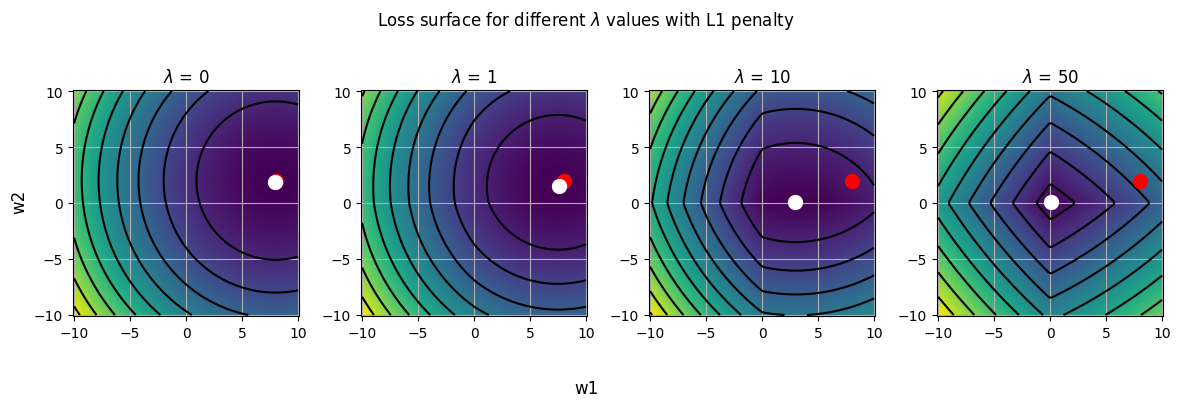

In [19]:
# create L2 penalty surface
pp = np.abs(w11) + np.abs(w22)

# lambda list
lambdas = [0, 1, 10, 50]

# plot loss surface
fig, ax = plt.subplots(1,4,figsize=(12,4))
for ind, lam in enumerate(lambdas):
    curr_loss = loss_fit + lam*pp
    ax[ind].pcolormesh(w11, w22, curr_loss)
    ax[ind].contour(w11, w22, curr_loss, 10, colors='k')
    ax[ind].plot(8, 2, 'ro', markersize=10)
    min_ind = np.argmin(curr_loss)
    ax[ind].plot(w11.flatten()[min_ind], w22.flatten()[min_ind], 'wo', markersize=10)
    ax[ind].set_title('$\lambda$ = ' + str(lam))
    ax[ind].grid()
    ax[ind].set_aspect('equal')
fig.supxlabel('w1')
fig.supylabel('w2')
fig.suptitle('Loss surface for different $\lambda$ values with L1 penalty')
fig.tight_layout()

The $loss$ landscape is quite different now. As $\lambda$ increases, the surface develops edges centered on the major axes of the graph. These drive the minimum towards 0, but first for the smaller weight, in this case `w2`. What this means is that the LASSO is not just shrinking the weights, but also *selecting* them, by forcing some to 0.

These are the two principal ways to penalize weights. Since they act on all the weights in a model, we do not have to preselect the features we want the model to train on.

Something you might be wondering is how to choose the value of $\lambda$. For that, we can fit the model multiple times to different values of $\lambda$, and then check how the model performs on the test data set. The $\lambda$ producing the lowest test error would be the one to use.

### Regularization with Scikit Learn
Scikit Learn offers a logistic regression that has cross-validated regularization built in, `LogisticRegressionCV`. It allows you to specify the type of penalty, L1 or L2 (or L1+L2, aka 'elasticnet') and the range of $\lambda$ values. The cross-validation routine used by `LogisticRegressionCV` is the `StratifiedKFold` cross-validation schedule that we used previously.

In [20]:
# initialize logistic regression model
log_mdl_l2 = LogisticRegressionCV(Cs=100, cv=5, penalty='l2', solver='liblinear', random_state=1)

The argument `Cs` specifies the $\lambda$ values to use. If we pass just an integer then we are setting the number of $\lambda$ values to try, ranging from $10^{-4}$ to $10^4$. `cv` determines the number of folds to split the dataset into. In this case with `cv=5`, 4 of the folds will be used for training and 1 will be held back for testing. For each value of $\lambda$, fitting will be performed for as many folds as were specified by `cv`. Lastly, `penalty` specifies the type of norm to use. Above we have decided to use the L2 norm, so we will be shrinking the weights instead of selecting them.

Once we have initialized the object, we can use its `fit` method just as we did for the regular `LogisticRegression` object. This can be followed up by a call to predict, to get the decoder's prediction based on the set of weights that had the lowest cross-validated error.

In [21]:
# fit logistic regression model
log_mdl_l2.fit(thumb_feats, thumb_lbls)

# get model predictions
thumb_preds_l2 = log_mdl_l2.predict(thumb_feats)

# get model accuracy
thumb_acc_l2 = balanced_accuracy_score(thumb_lbls, thumb_preds_l2)
print('Thumb movement decoding accuracy: {:0.2f}%'.format(thumb_acc_l2*100))

Thumb movement decoding accuracy: 100.00%


We are back up to nearly 100% accuracy. This could be very good. Let's see what $\lambda$ value was settled on.

In [22]:
def get_lambdas(log_mdl):
    """
    Function to get lambda values from a logistic regression model.

    Parameters
    ----------
    log_mdl : sklearn.linear_model.LogisticRegressionCV
        Logistic regression model.

    Returns
    -------
    lambdas : array
        Array of lambda values.
    lambda_best : float
        Lambda value with best performance.
    lambda_best_ind : int
        Index of lambda_best in lambdas.
    """

    # get all lambdas tested
    lambdas = 1/log_mdl.Cs_

    # get the lambda with the best performance
    lambda_best = 1/log_mdl.C_
    lambda_best_ind = np.where(lambdas==lambda_best)[0][0]

    return lambdas, lambda_best, lambda_best_ind

lambdas_l2, lambda_best_l2, lambda_best_ind_l2 = get_lambdas(log_mdl_l2)
print('Best lambda: {}, at index {} of {} in lambda list'.format(lambda_best_l2, lambda_best_ind_l2, lambdas_l2.size))

Best lambda: [0.0559081], at index 65 of 100 in lambda list


Looks like the lambda we used was greater than the minimum (0.0001), so the fitting settled on coefficients that were affected by the penalty. It is often helpful to visualize the performance of the decoder as a function of lambda. This is similar to what we did with the polynomial fit above, when we plotted the mean squared error on the test data as a function of the polynomial order. In the case of the `LogisticRegressionCV` object, we can get an attribute called `scores_`, which gives the performance for the model on each test fold. It is stored as a dictionary, with the key being the class, in our case there is just one, '1.0', since we are only detecting thumb flexions. Inside that, the scores are stored as a numpy array with fold along the row axis and lambdas along the column axis. We will take the mean across folds, so that we get a single measure of performance for every lambda value.

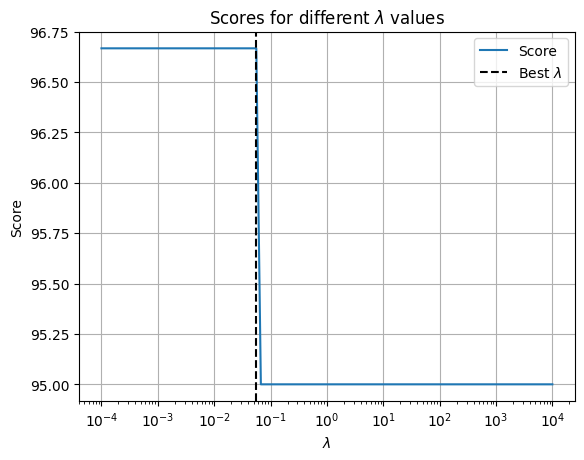

In [23]:
def plot_scores(log_mdl, ax=None):
    """
    Function to plot scores for each lambda value.

    Parameters
    ----------
    log_mdl : sklearn.linear_model.LogisticRegressionCV
        Logistic regression model.
    ax : matplotlib.axes.Axes
        Axis to plot on.
    """

    if ax is None:
        ax = plt.gca()

    # get all lambdas tested
    lambdas, lambda_best, lambda_best_ind = get_lambdas(log_mdl)

    # get scores for each lambda
    scores = np.mean(log_mdl.scores_[1.0], axis=0)*100

    # plot scores for each lambda
    ax.plot(lambdas, scores, label='Score')
    ax.axvline(lambda_best, linestyle='dashed', color='k', label='Best $\lambda$')
    ax.set_xscale('log')
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('Score')
    ax.legend()
    ax.set_title('Scores for different $\lambda$ values')
    ax.grid()

# plot scores for each lambda
fig, ax = plt.subplots()
plot_scores(log_mdl_l2, ax=ax)

The `LogisticRegressionCV` class has chosen a $\lambda$ with an intermediate value. It went for the one with the highest performance and largest value. In addition to visualizing how the score changes with $\lambda$, we can inspect how the weights change as a function of lambda. This will give us an intuition for how the L2 norm operates.

The most common way to plot the weight change is to use a coefficient path plot. For this, we plot each coefficient as a line with respect to the lambda value.

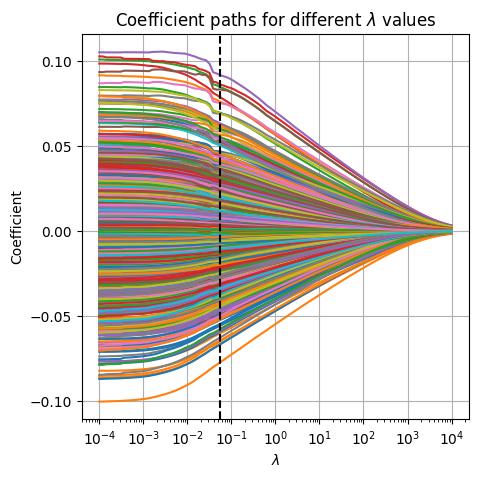

In [24]:
def plot_coef_paths(log_mdl, ax=None):
    """
    Function to plot coefficient paths for each lambda value.

    Parameters
    ----------
    log_mdl : sklearn.linear_model.LogisticRegressionCV
        Logistic regression model.
    ax : matplotlib.axes.Axes
        Axis to plot on.
    """

    if ax is None:
        ax = plt.gca()

    # get all lambdas tested
    lambdas, lambda_best,_ = get_lambdas(log_mdl)

    # plot coefficient path for each coefficient
    for i in range(log_mdl.coefs_paths_[1.0].shape[2]-1): # -1 to exclude intercept
        ax.plot(lambdas, np.mean(log_mdl.coefs_paths_[1.0][:,:,i], axis=0))

    # plot vertical line at best lambda
    ax.axvline(lambda_best, linestyle='dashed', color='k', label='Best $\lambda$')
    ax.set_xscale('log')
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('Coefficient')
    ax.set_title('Coefficient paths for different $\lambda$ values')
    ax.grid()

# plot coefficient paths for each lambda
fig, ax = plt.subplots(figsize=(5,5))
plot_coef_paths(log_mdl_l2, ax=ax)


You can really see the shrinkage! The weights are gradually downscaled towards 0 as $\lambda$ increases. Curiously, the amount of weight diminishment required to reduce the overfitting is small. And further reduction does not improve performance. Still, it is hard to visualize what this means for the neural signals that are driving the decoder. It is unclear from the plotted lines what channels are frequency bands have the largest weights, and the most reduction. Instead of doing the traditional coefficient path plot, we could instead plot the weights as spectrums on each channel, and capture the variation in $\lambda$ by animating the plot.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgba -framerate 3.3333333333333335 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/tmpn706lbdl/temp.m4v


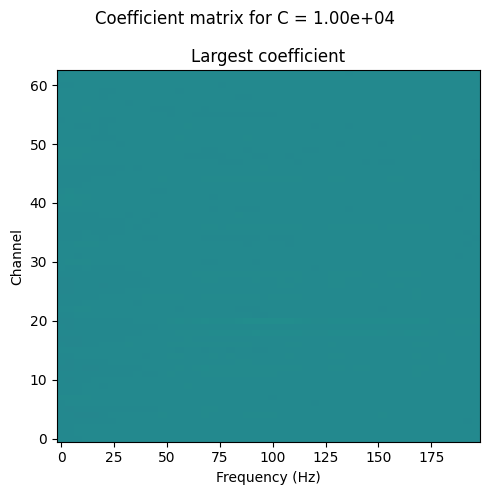

In [25]:
def plot_anim_coefs(log_mdl, ax=None):
    """
    Function to plot an animated pcolormesh of coefficients for each lambda value.

    Parameters
    ----------
    log_mdl : sklearn.linear_model.LogisticRegressionCV
        Logistic regression model.
    ax : matplotlib.axes.Axes
        Axis to plot on.

    Returns
    -------
    anim : matplotlib.animation.FuncAnimation
        Animation of coefficients as a function of lambda.
    """

    if ax is None:
        ax = plt.gca()

    # get all lambdas tested
    lambdas, _, lambda_best_ind = get_lambdas(log_mdl)

    # create animation of coefficients as a function of lambda plotted with imshow
    max_coef = np.max(log_mdl.coefs_paths_[1.0][:,lambda_best_ind,:-1])
    min_coef = np.min(log_mdl.coefs_paths_[1.0][:,lambda_best_ind,:-1])
    
    def animate(i):
        ax.clear()
        coef_mat = np.mean(log_mdl.coefs_paths_[1.0][:,-i,:-1], axis=0).reshape(63,-1)
        coef_mat[coef_mat==0] = np.nan
        ax.pcolormesh(f, np.arange(63), coef_mat, vmin=min_coef, vmax=max_coef)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Channel')
        ax.set_title('Largest coefficient')
        fig.suptitle('Coefficient matrix for C = {:0.2e}'.format(lambdas[-i]))
        fig.tight_layout()
        return ax

    anim = animation.FuncAnimation(fig, animate, frames=lambdas.size, interval=300, blit=False)
    return anim

fig, ax = plt.subplots(figsize=(5,5))
anim_l2 = plot_anim_coefs(log_mdl_l2, ax=ax)
HTML(anim_l2.to_html5_video())

The weights resemble the mean spectrum calculated earlier, except downscaled. As $\lambda$ increases the contrast in the weights seem to fade towards zero, with the same pattern maintained throughout.

All of this fits the L2 norm performing shrinkage on the weights. 

Let's now try the L1 norm as the penalty.

In [26]:
# initialize logistic regression model
log_mdl_l1 = LogisticRegressionCV(Cs=100, cv=5, penalty='l1', solver='liblinear', random_state=1)

log_mdl_l1.fit(thumb_feats, thumb_lbls)

# get model predictions
thumb_preds_l1 = log_mdl_l1.predict(thumb_feats)

# get model accuracy
thumb_acc_l1 = balanced_accuracy_score(thumb_lbls, thumb_preds_l1)
print('Thumb movement decoding accuracy: {:0.2f}%'.format(thumb_acc_l1*100))

Thumb movement decoding accuracy: 100.00%


Switching to an L1 penalty gives a performance of 100%, just as with L2. However, since L1 performs both shrinkage and selection, the way it achieves this may be different. To see how, let's take a look at the error and weight curves as a function of $\lambda$.

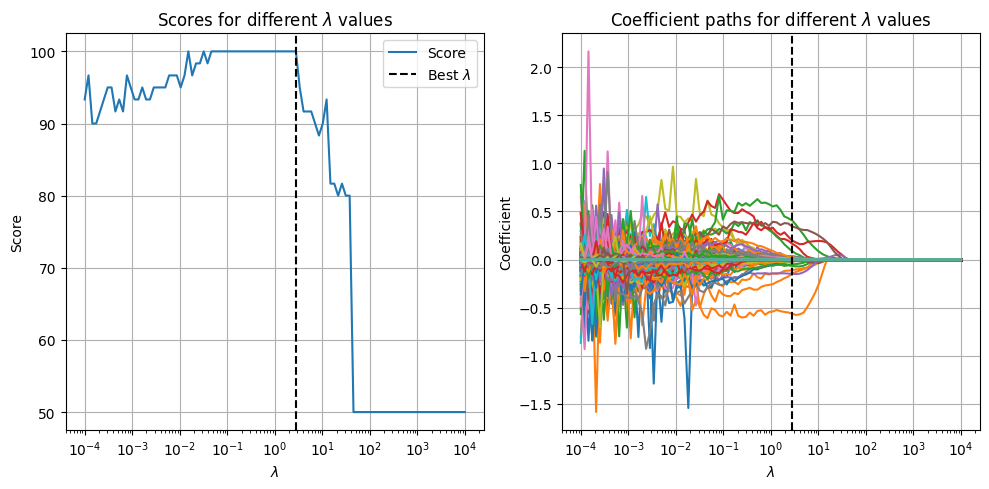

In [27]:
# Create two subplots, one of scores and the other of coefficient paths
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_scores(log_mdl_l1, ax=ax[0])
plot_coef_paths(log_mdl_l1, ax=ax[1])
fig.tight_layout()


This is a bit more interesting than the L2 norm. The performance is worse when $\lambda$ is less than 0.1, then peaks, before falling down again at $\lambda$ values past 10. This *inverted-U* shaped relationship between $\lambda$ and performance is commonly observed. For very small values of $\lambda$, the model performs comparably to there being no penalty. As $\lambda$ increases, some weights begin to drop out, and other increase to aid in decodig. Further increasing $\lambda$ starts to diminish those enhanced weights, and here performance peaks. Eventually, $\lambda$ is so large that the penalty selects out all weights, and decoder performance drops to chance levels.

We can visualize the evolution of the weights using the same animated plot as we did for L2.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgba -framerate 3.3333333333333335 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/tmphs46i6xq/temp.m4v


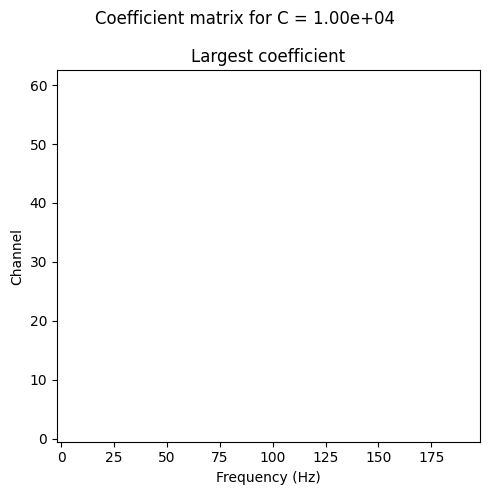

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
anim_l2 = plot_anim_coefs(log_mdl_l1, ax=ax)
HTML(anim_l2.to_html5_video())

Notice how some coefficients are set to 0 (white pixels) and the density of those increases with larger values of $\lambda$. For many channel/frequency combinations the weights toggle seemingly randomly between selected or not selected. But, for those channels/frequencies that showed the strongest response to the thumb movement they remain selected until lambda reaches very high values. Thus, the L1 penalty tends to keep in the model only those channels/frequencies that had the strongest relationship with thumb movement.

To summarize, we can compare the coefficients across the models.

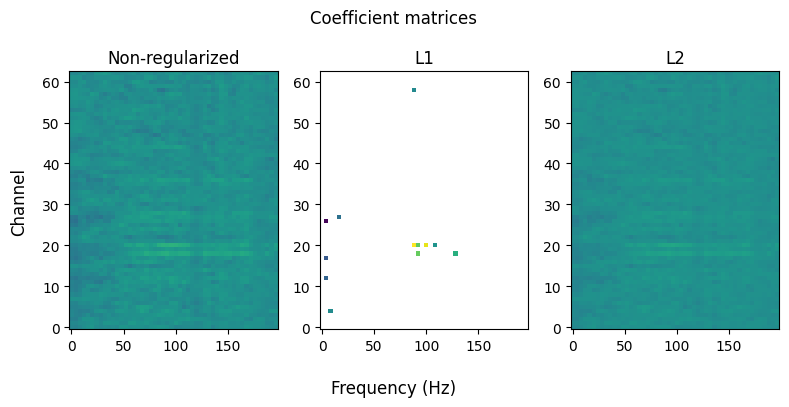

In [29]:
# plot coefs for non-regularized, L1, and L2 norms
fig, ax = plt.subplots(1,3,figsize=(8,4))
coefs_nonreg = log_mdl.coef_.reshape(63,-1)
ax[0].pcolormesh(f, np.arange(63), coefs_nonreg, vmin=-0.5, vmax=0.5)
ax[0].set_title('Non-regularized')
coefs_l1 = log_mdl_l1.coef_.reshape(63,-1)
coefs_l1[coefs_l1==0] = np.nan
ax[1].pcolormesh(f, np.arange(63), coefs_l1, vmin=-0.5, vmax=0.5)
ax[1].set_title('L1')
coefs_l2 = log_mdl_l2.coef_.reshape(63,-1)
ax[2].pcolormesh(f, np.arange(63), coefs_l2, vmin=-0.5, vmax=0.5)
ax[2].set_title('L2')
fig.suptitle('Coefficient matrices')
fig.supxlabel('Frequency (Hz)')
fig.supylabel('Channel')
fig.tight_layout()


 No regularization produces a dense set of weights where even frequency/channel pairs that are not associated with thumb flexion have substantial weights. L1 is performing selection and enhancement of weights, leaving only a sparse set of frequency/channel weights driving the decoding decision. Lastly, L2 reduces the strength of all weights, but mostly for those that are not relevant to thumb flexion. 

## Hyperparameter optimization 
During fitting we are optimizing the coefficients and bias. However, where does that leave the $\lambda$ parameter? We do not explicitly optimize it during fitting, because we do not adapt its value using the gradient descent procedure. Instead, we try a variety of $\lambda$ values and then select the model whose $\lambda$ had the best performance on the test data. 

Parameters such as $\lambda$ that affect the fitting process but are not explicitly optimized are known as *hyperparameters*. There are many other hyperparameters when fitting models that we set, such as the learning rate or momentum terms used with stochastic gradient descent. Another is the size of the training and test data sets. We choose how much data to use for training, and keep in reserve for testing.

To explore how these factors contribute to decoding, we will reimplement our ECoG logisitic decoder with PyTorch.

### ECoG logistic decoder with PyTorch
To study the effect of hyperparameters on model fitting, we will reimplement logistic regression with PyTorch. Unlike our previous implementation, this version will support multiple features. To start, let's create the `Dataset` object for our ECoG data. Recall that a PyTorch `Dataset` object, when passed to the `Dataloader`, facilitates the conversion of the training data into a form that is easily ingested by an optimization algorithm. 

In [30]:

class ECoGData(Dataset):
    def __init__(self, ecog_feat, ecog_lbl, transform=None, target_transform=None):
        # Parameters
        # ----------
        # ecog_feat : array-like
        #     Array of features, where each row is a trial and each column is a feature
        # ecog_lbl : array-like
        #     Array of labels, where each element is the label for the corresponding row in ecog_feat
        # transform : callable, optional
        #     Optional transform to be applied to the ecog data
        # target_transform : callable, optional
        #     Optional transform to be applied to the trial label

        self.ecog_feat = ecog_feat
        self.ecog_lbl = ecog_lbl
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Returns
        # -------
        # len : int
        #     Number of samples in the dataset

        return len(self.ecog_lbl)
    
    def __getitem__(self, idx):
        # Parameters
        # ----------
        # idx : int
        #     Index of the sample to return

        # Returns
        # -------
        # erp : array-like
        #     ECoG data for the selected sample
        # lbl : array-like
        #     Trial label for the selected sample
        
        feat = self.ecog_feat[idx].astype(np.float32) # get the ECoG data for the selected sample
        lbl = self.ecog_lbl[idx] #.astype(np.float32).reshape(-1,1) # get the trial label for the selected sample
        if self.transform is not None: # apply the transform to the ECoG data
            feat = self.transform(feat)
        if self.target_transform is not None: # apply the transform to the trial label
            lbl = self.target_transform(lbl)
        return feat, lbl

Now we will create the multifeature logistic regression class. While the model will be implemented using functions and objects from the PyTorch package, the class will have the methods found in a SciKit learn estimator object. The user will have access to various hyperparameters that can be setup during initialization. These include learning rate (`lr`), proportion of data to train on (`train_prop`), number of samples used for each optimization step (`batch_size`), the number of passes through the training dataset used for optimization (`epochs`), and lambda for an L1 penalty (`lam`).

In [31]:
class LogRegPT():
    def __init__(self, lr=0.01, epochs=100, train_prop=0.8, batch_size=5, lam=0.0):
        """
        Initialize logistic regression model.
        
        Parameters
        ----------
        lr : float, optional
            Learning rate for gradient descent
        epochs : int, optional
            Number of epochs to train for
        n_folds : int, optional
            Number of folds for cross-validation
        batch_size : int, optional
            Number of samples per batch
        lam : float, optional
            Regularization parameter for L1 norm
        """

        self.lr = lr
        self.epochs = epochs
        self.train_prop = train_prop
        self.batch_size = batch_size
        self.lam = lam
        self.logreg_ = None
    
    def create_logreg_(self, input_dim):
        """
        Create logistic regression model.

        Parameters
        ----------
        input_dim : int
            Number of input features
        """

        # linear layer is the weights and bias
        # input_dim is the number of input features and 1 is the number of output features
        # this is taking the dot product of the input features with the weights and adding the bias
        lin_layer = torch.nn.Linear(input_dim, 1)

        # sigmoid layer is the activation function
        sig_layer = torch.nn.Sigmoid()

        # logistic regression model is a sequential combination of linear and sigmoid layers
        logreg = torch.nn.Sequential(
            lin_layer,
            sig_layer
        )
        self.logreg_ = logreg
    
    def create_loss_(self):
        # initialize loss function
        return torch.nn.BCELoss(reduction='mean')

    def create_optim_(self):
        # initialize optimizer
        return torch.optim.SGD(self.logreg_.parameters(), lr=self.lr)
    
    def fit(self, X, y):
        """
        Fit logistic regression model

        Parameters
        ----------
        X : array-like
            Array of features, where each row is a trial and each column is a feature
        y : array-like
            Array of labels, where each element is the label for the corresponding row in X

        Returns
        -------
        score_test : float
            Balanced accuracy score for testing data
        score_train : float
            Balanced accuracy score for training data
        """

        # initialize model and fitting
        feat_num = X.shape[1]
        self.create_logreg_(feat_num)
        optim = self.create_optim_()
        loss_fn = self.create_loss_()
        
        # split data into train and test sets
        train_num = int(self.train_prop*X.shape[0])
        train_idxs = np.random.permutation(X.shape[0])[:train_num]
        test_idxs = np.setdiff1d(np.arange(X.shape[0]), train_idxs)

        if train_idxs.size < self.batch_size:
            raise ValueError('Number of training samples smaller than batch size')
        
        # create data loaders for train and test sets
        train_ds = ECoGData(X[train_idxs,:], y[train_idxs])
        train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        test_ds = ECoGData(X[test_idxs,:], y[test_idxs])
        
        # train model
        self.logreg_.train()
        for epoch in range(self.epochs):
            for feat, lbl in train_dl:
                optim.zero_grad()
                pred = self.logreg_(feat)
                loss = loss_fn(pred, lbl.float().reshape(-1,1))

                # add L1 regularization
                loss += self.lam*torch.sum(torch.abs(self.logreg_[0].weight)) 
                
                loss.backward()
                optim.step()
            
        # get predictions for test set
        self.logreg_.eval()
        with torch.no_grad():
            pred = self.logreg_(torch.tensor(test_ds.ecog_feat.astype(np.float32)))
            pred = pred.squeeze().numpy()
            pred[pred>=0.5] = 1
            pred[pred<0.5] = 0
            score_test = balanced_accuracy_score(test_ds.ecog_lbl, pred)

        # get predictions for train set
        with torch.no_grad():
            pred = self.logreg_(torch.tensor(train_ds.ecog_feat.astype(np.float32)))
            pred = pred.squeeze().numpy()
            pred[pred>=0.5] = 1
            pred[pred<0.5] = 0
            score_train = balanced_accuracy_score(train_ds.ecog_lbl, pred)
        
        # return test and train scores for evaluating model generalization
        return score_test*100, score_train*100

    def predict(self, X):
        """
        Predict labels

        Parameters
        ----------
        X : array-like
            Array of features, where each row is a trial and each column is a feature

        Returns
        -------
        pred : array-like
            Predicted labels
        """

        if self.logreg_ is None:
            raise ValueError('Logistic regression model has not been fit yet.')
        
        self.logreg_.eval()

        X = torch.tensor(X.astype(np.float32))
        
        with torch.no_grad():
            pred = self.logreg_(X)
            pred = pred.squeeze().numpy()
            pred[pred>=0.5] = 1
            pred[pred<0.5] = 0
        return pred
    
    def get_coefs(self):
        """
        Get coefficients

        Returns
        -------
        coefs : array-like
            Coefficients for each feature
        """

        if self.logreg_ is None:
            raise ValueError('Logistic regression model has not been fit yet.')
        
        self.logreg_.eval()
        with torch.no_grad():
            coefs = self.logreg_[0].weight.numpy().squeeze()
        return coefs
    
    def get_intercept(self):
        """
        Get intercept

        Returns
        -------
        intercept : float
            Intercept value
        """

        if self.logreg_ is None:
            raise ValueError('Logistic regression model has not been fit yet.')
        
        self.logreg_.eval()
        with torch.no_grad():
            intercept = self.logreg_[0].bias.numpy().squeeze()
        return intercept

The `fit` method contains the crucial code to generate a multifeature logistic regression model. Unlike the single feature version we created previously, this new one includes an L1 penalty term. We do this by first calculating the loss based on the binary cross-entropy (`BCELoss`), and then adding the L1 penalty term to that loss. To calculate the L1 penalty for the PyTorch model, we extract the weights in the linear layer, take their absolute value and add them together, then multiply by `lam` ($\lambda$). Once this is added to loss, the L1 penalty gets factored into the calculation of the gradients that are used to update the weights.

Since we want to iterate over a range of values for each hyperparameter, and we want to explore how multiple hyperparameters contribute to the fitting, we will create functions to faciliate this. As a general rule in programming, if you find yourself writing the same code multiple times, then it should be encapsulated into a function. This reduces the number of lines of code you have to produce. It also makes it easier to update your code, since you only have to change the code within the function, instead of changing the same section in each of the repetitions.

To examine how changes in a hyperparameter affects model performance, we will create the method `hyper_cv`. This stands for hyperparameter cross-validation, which takes data and hyperparameters, and fits the model to each combination of hyperparameters, and does this for a user specified number of times, `n`. Next we want to plot the results, and for that we create the function `plot_hyper_cv`. This takes the train and test scores, along with a list of strings representing the corresponding parameters, and create violin plots showing the distribution of these scores for each hyperparameter set.

In [32]:
def hyper_cv(feats, lbls, n=100, verbose=False, **kwargs):
    """
    Function to perform hyperparameter cross-validation for logistic regression.

    Parameters
    ----------
    feats : array-like
        Array of features, where each row is a trial and each column is a feature.
    lbls : array-like
        Array of labels, where each element is the label for the corresponding row in feats.
    n : int, optional
        Number of times to run cross-validation.
    verbose : bool, optional
        Whether to print progress.
    **kwargs : dict
        Keyword arguments for LogRegPT.

    Returns
    -------
    scores_test : array-like
        Array of test scores for each run.
    scores_train : array-like
        Array of train scores for each run.
    param_list : list
        List of parameter combinations used.
    """

    # create all combinations of parameters
    # we use the product function from itertools to create all combinations of parameters
    param_list = list(product(*kwargs.values()))

    scores_test = np.zeros([n, len(param_list)])
    scores_train = np.zeros(scores_test.shape)
    for i in range(n):
        if verbose and (i%10==0):
            print('Run {} of {}'.format(i+1, n))
        for j, param in enumerate(param_list):
            param_dict = dict(zip(kwargs.keys(), param))
            logreg_pt = LogRegPT(**param_dict)
            scores_test[i,j], scores_train[i,j] = logreg_pt.fit(feats, lbls)
    
    return scores_test, scores_train, param_list

# violin plot of scors for each parameter
def plot_hyper_cv(test, train, param_strs, ax=None):
    """
    Function to plot hyperparameter cross-validation scores.
    
    Parameters
    ----------
    test : array-like
        Array of test scores for each run. 
        Rows are runs and columns are parameter combinations.
    train : array-like
        Array of train scores for each run. 
        Rows are runs and columns are parameter combinations.
    param_strs : list of str
        List of parameter combinations used.
    ax : matplotlib.axes.Axes
        Axis to plot on.

    Returns
    -------
    ax : matplotlib.axes.Axes
        Axis with violin plot.
    """

    if ax is None:
        ax = plt.gca()

    num_params = len(param_strs)
    train_parts = ax.violinplot(train, positions=np.arange(num_params)*2+0.5, 
                                showmedians=True)
    test_parts = ax.violinplot(test, positions=np.arange(num_params)*2, 
                                showmedians=True)
    
    # create legend for test and train scores
    ax.legend([test_parts['bodies'][0], train_parts['bodies'][0]], 
                ['Test', 'Train'], loc='lower left')

    ax.set_xticks(np.arange(num_params)*2+0.25)
    ax.set_xticklabels(param_strs)
    ax.set_xlabel('Parameters')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim([0, 110])
    ax.grid(axis='y')
    return ax


### Effect of $\lambda$
We already covered how an L1 penalty can affect fitting using the `LogisticRegression` classifier from SciKit learn, so it should perform similarly when reimplmented with PyTorch. Here we vary lambda from 0 to $10^10$.

Text(0.5, 0, 'Lambda (log10)')

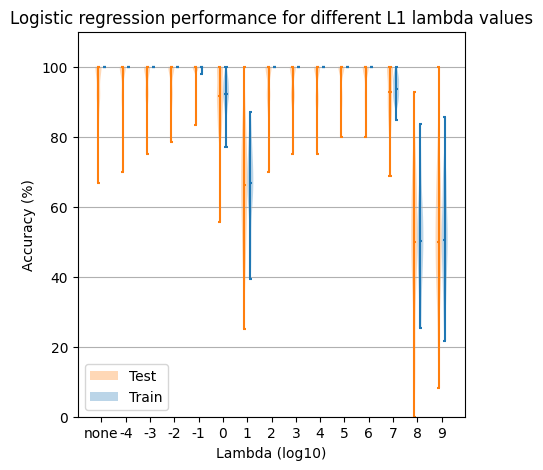

In [34]:
lams = np.hstack((0,10.0**np.arange(-4,10)))
scores_test, scores_train, params = hyper_cv(thumb_feats, thumb_lbls, lam=lams, batch_size=[20])
fig, ax = plt.subplots(figsize=(5,5))
param_strs = list(map(str, np.log10(lams[1:]).astype(int)))
param_strs.insert(0, 'none')
plot_hyper_cv(scores_test, scores_train, param_strs, ax=ax)
ax.set_title('Logistic regression performance for different L1 lambda values')
ax.set_xlabel('Lambda (log10)')

When $\lambda$ is zero, that is when no L1 penalty is used, our training accuracy is 100% and testing is around 95%. Increasing $\lambda$ leads to a degradation in performance for training and test data, followed by an improvement on par with the absence of regularization, and then a dramatic drop to chance performance. The best performance was at $\lambda=0.1$, where the distribution of test set accuracy scores was tightest.

### Effect of learning rate
Learning rate determines how much we adjust the weights with each optimization step. The effect of this on final performance will depend on the number of training epochs we give, which we have set at 100 by default. Here we will vary the learning rate over 10 orders of magnitude.

Text(0.5, 0, 'Learning rate (log10)')

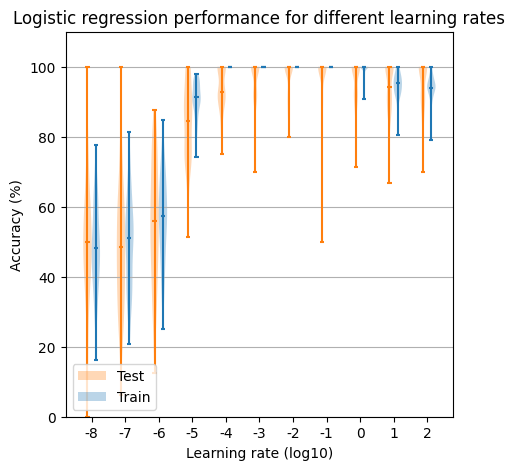

In [34]:
lrs = 10.0**np.arange(-8,3)
scores_test, scores_train, params = hyper_cv(thumb_feats, thumb_lbls, lr=lrs)
fig, ax = plt.subplots(figsize=(5,5))
param_strs = list(map(str, np.log10(lrs).astype(int)))
plot_hyper_cv(scores_test, scores_train, param_strs, ax=ax)
ax.set_title('Logistic regression performance for different learning rates')
ax.set_xlabel('Learning rate (log10)')

When the values are set very low, performance for both training and testing data is poor, since the weights cannot move quickly enough over the 100 epochs to reach the minimum in the loss landscape. As learning rate increases, the optimization can converge on that minimum and performance on the training and test data increases. Turning the learning rate up even higher leads to a degradation in performance, since now the weight updates will tend to overshoot the minimum.

### Effect of batch size
When training with stochastic gradient descent, we can choose how many samples are used to calculate the gradient for each optimization step. If all the samples are used, then this is regular gradient descent. If less than the total are used, then we have to randomly select some samples, and that is the *stochastic* part of stochastic gradient descent. Each of these randomly selected subsets of samples is referred to as a *minibatch*, and their size can impact the fitting process. When we have cycled through all minibatches in our training data, a new epoch is started and we run through the data again. If we use a batch size of 1, then we update the model weights based on the performance with each sample. As the batch size increases, we average the losses over samples when calculating the updates.

Text(0.5, 0, 'Batch size')

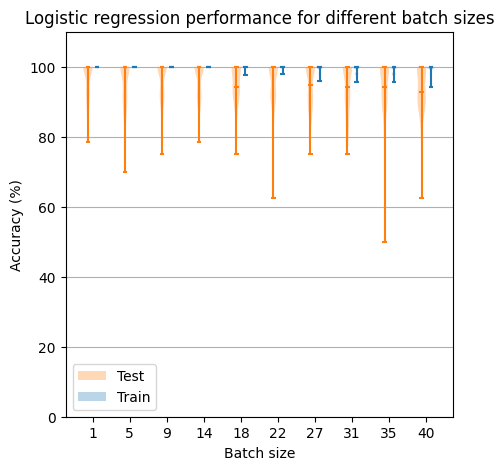

In [35]:
batch_sizes = np.linspace(1, 40, 10).astype(int).tolist()
scores_test, scores_train, params = hyper_cv(thumb_feats, thumb_lbls, 
                                             batch_size = batch_sizes, epochs=[25], lr=[0.001])
fig, ax = plt.subplots(figsize=(5,5))
param_strs = list(map(str, batch_sizes))
plot_hyper_cv(scores_test, scores_train, param_strs, ax=ax)
ax.set_title('Logistic regression performance for different batch sizes')
ax.set_xlabel('Batch size')

Varying the batch size, we find that performance is best for smaller batches, and degrades with batch sizes approaching the overall size of our dataset. Thus, you might be inclined to go with updates after each sample, i.e. batches of 1. The compromise here is that it is computationally less efficient to calculate the model predictions and update the gradients with just a single sample. PyTorch and other machine learning libraries can make use of computer hardware, such as GPUs, that allow for multiple samples to be processed in parallel, speeding up computation. Thus, batch sizes are increased to benefit from the performance improvement of a smaller batch, while minimizing time needed to compute.

### Effect of training data amount
The amount of data used for training should impact performance. Here we vary it from 10 to 90% of the dataset.

Text(0.5, 0, 'Training data size (proportion)')

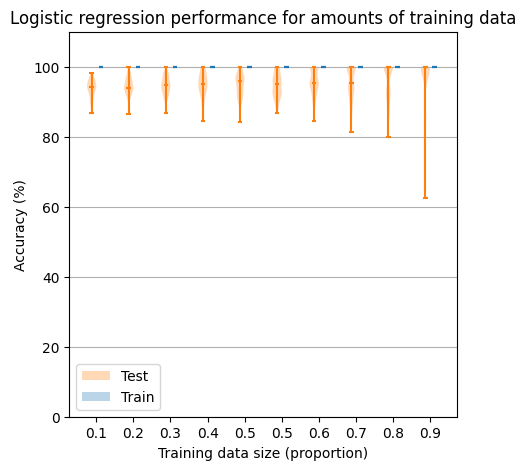

In [36]:
train_props = np.linspace(0.1, 0.9, 10)
scores_test, scores_train, params = hyper_cv(thumb_feats, thumb_lbls, 
                                             train_prop = train_props)
fig, ax = plt.subplots(figsize=(5,5))
param_strs = list(map(lambda x: '{:0.1f}'.format(x), train_props))
plot_hyper_cv(scores_test, scores_train, param_strs, ax=ax)
ax.set_title('Logistic regression performance for amounts of training data')
ax.set_xlabel('Training data size (proportion)')

Irrespective of the training dataset size, perfect performance can be achieved on the training data. However, performance on the test data is poorer when only 10% of the training data is provided, and improves as it is increased. This is because more training data allows the fitting to learn a greater variety of relationships between features and labels, which improves generalization to the test set. Note also that the variance in the performance on the test data increases as more data is devoted to training. This is because less data is given for testing, and so performance on the test data set becomes increasingly variable as it comes to depend on which specific trials are used for the test. Perhaps unsurprisingly, the proportion that seems to minimize this variance in the performance on the test data while maximizing its average value is a proportion of 0.8, equivalent to the standard 5-fold cross-validation.

### Putting them all together
Now that we have found the optimal values of the hyperparameters for each setting, we can put them all together when training our model. The assumption here is that if a certain parameter results in improved performance, it will not result in decreased performance when combined with the ideal value of another parameter. This is a reasonable starting assumption to make, however it can also be wrong. Thus, exploring the contribution of each hyperparameter on training individually, and then using the best values in combination, is only the first step to optimizing the training of a model. Let's try training a model now using the optimal hyperparameter values we found above.

Median train accuracy: 100.00 %
Median test accuracy: 100.00 %


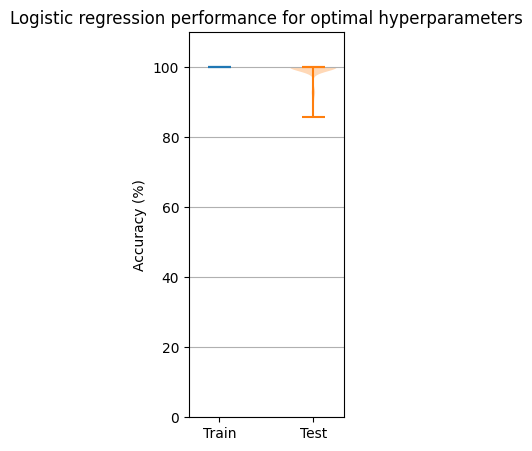

In [36]:
num_runs = 100
scores_test = np.zeros(num_runs)
scores_train = np.zeros(num_runs)
for i in range(num_runs):
    opt_mdl = LogRegPT(lr=0.01, train_prop=0.8, batch_size=1, lam=0.1)
    scores_test[i], scores_train[i] = opt_mdl.fit(thumb_feats, thumb_lbls)

fig, ax = plt.subplots(figsize=(2,5))
ax.violinplot(scores_train, positions=[1], showmedians=True)
ax.violinplot(scores_test, positions=[2], showmedians=True)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([0, 110])
ax.grid(axis='y')
ax.set_title('Logistic regression performance for optimal hyperparameters')

# print median performance for train and test sets
print('Median train accuracy: {:.2f} %'.format(np.median(scores_train)))
print('Median test accuracy: {:.2f} %'.format(np.median(scores_test)))


Combining the optimal hyperparameter values seems to improve performance on the testing set. Compared to the Scikit Learn performance, which was ~96% for the test set without hyperparameter optimization, we now get 100% on the test set.

## Train, test, and validation data sets
So far we have been relying on cross-validation to assess the performance of our decoder. We have done this because the fitting procedure optimizes for the training data, and may be prone to memorizing specific features of that data, which will not generalize to held out data. We have tried to control for memorization using regularization and hyperparameter tuning, which allows us to test a variety of training schemes and select the one that perfroms the best on the test data. Unfortunately, this scheme does not ensure that we get an estimate of decoder performance that reflects how it will do on new data. This is because we have optimized our hyperparameters for performance on the training data set, so we are implicitly fitting to that. This is compounded by the fact that use a different subset of the data for testing each time we run our fitting, some of which is used for the training in other fitting runs. Thus, we may have some *information leakage* in our test data when selecting for the optimal hyperparameter.

To minimize this, after the hyperparameters have been fit we would want to test our model performance on data that was neither used for training or testing. We refer to this subset of data as the *validation set*. The performance of the hyperparameter optimized model on the validation data will be a truer estimate of how it would perform on an entirely new set of samples. Indeed, if the whole point of a decoder is to predict stimuli or behaviors from brain activity in real time, then our decoder must perform well on data it has never been trained or optimized on.

Incorporating a validation data set into our fitting procedure is simple. We just have to divide our data into three groups, and hold out the validation samples until after all cross-validated optimizations have been completed.

In [39]:
print(i)

8


/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Mean train accuracy: 100.00 %
Mean test accuracy: 99.50 %
Mean validation accuracy: 97.50 %


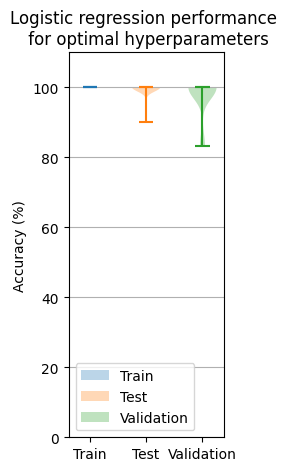

In [40]:
# set random number generator to ensure reproducibility
np.random.seed(8)
torch.manual_seed(8)

num_runs = 20
scores_test = np.zeros(num_runs)
scores_train = np.zeros(num_runs)
scores_val = np.zeros(num_runs)
best_lambdas = np.zeros(num_runs)

# train using cross-validation multiple times to get a distribution of scores
# evaluate cross-validated model performance on validation data
for i in range(num_runs):
    # split into train/test and validation data sets. Approximately 10% of data is validation, 90% is for train/test
    [tt_inds, val_inds] = next(StratifiedKFold(n_splits=10, shuffle=True).split(thumb_feats, thumb_lbls))

    # create train/test and validation datasets
    tt_feats = thumb_feats[tt_inds,:]
    tt_lbls = thumb_lbls[tt_inds]
    val_feats = thumb_feats[val_inds,:]
    val_lbls = thumb_lbls[val_inds]

    # identify optimal lambda using train/test data
    lams = np.hstack((0,10.0**np.arange(-1,7)))
    scores_cv_test,_,_ = hyper_cv(tt_feats, tt_lbls, lr=[0.01], train_prop=[0.8], batch_size=[14], lam=lams)

    best_lambdas[i] = lams[np.argmax(np.mean(scores_cv_test, axis=0))]

    # refit model with optimal lambda
    # set data_prop to 0.9 so that we use 90% of the data for training, which refl
    log_mdl_best = LogRegPT(batch_size=20, lam=best_lambdas[i], train_prop=0.9)
    scores_test[i], scores_train[i] = log_mdl_best.fit(tt_feats, tt_lbls)

    # get model predictions for validation data
    val_preds = log_mdl_best.predict(val_feats)

    # get model accuracy for validation data
    scores_val[i] = balanced_accuracy_score(val_lbls, val_preds)*100

# plot violin plot of scores compared across train and test sets
fig, ax = plt.subplots(figsize=(2,5))
v_train = ax.violinplot(scores_train, positions=[1], showmedians=True)
v_test = ax.violinplot(scores_test, positions=[2], showmedians=True)
v_val = ax.violinplot(scores_val, positions=[3], showmedians=True)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Train', 'Test', 'Validation'])
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([0, 110])
ax.grid(axis='y')
ax.set_title('Logistic regression performance \n for optimal hyperparameters')
ax.legend([v_train['bodies'][0], v_test['bodies'][0], v_val['bodies'][0]], ['Train', 'Test', 'Validation'], loc='lower left')

print('Mean train accuracy: {:.2f} %'.format(np.mean(scores_train)))
print('Mean test accuracy: {:.2f} %'.format(np.mean(scores_test)))
print('Mean validation accuracy: {:.2f} %'.format(np.mean(scores_val)))

As we had seen previously, performance on the training data tended to exceed that on the test data. In addition, when we examine how the cross-validation optimized model performs on the held out validation data, we find performance to be worse. This suggests that the process of selecting the optimal hyperparameter via cross-validation causes some leakage of information about the testing data, or is otherwise biased towards better performance on it. By holding the validation data in reserve after all fitting and hyperparameter optimization has been performed, we obtain a better estimate of how our model will perform on newly acquired data. Ultimately, this better reflects the actual BCI use case.

## Code summary